In [25]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error


# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
pd.set_option('display.max_columns', None)

In [27]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [28]:
pd.set_option('display.max_rows', None)

In [29]:
agg_strats = ['mean']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

predictions, y_test = m_wrap.get_test(aggregated=True)


['elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2']
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
['elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2']


# Model 1

In [30]:
agg_strats = ['min','max']
rand_incr = 1
name = 'MinMax'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg, _ = m_wrap.get_test(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

['elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2']
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
['elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2']
0:	learn: 0.1476002	total: 244ms	remaining: 3m 14s
1:	learn: 0.1438398	total: 393ms	remaining: 2m 36s
2:	learn: 0.1399340	total: 515ms	remaining: 2m 16s
3:	learn: 0.1361832	total: 657ms	remaining: 2m 10s
4:	learn: 0.1326156	total: 794ms	remaining: 2m 6s
5:	learn: 0.1293522	total: 921ms	remaining: 2m 1s
6:	learn: 0.1259468	total: 1.04s	remaining: 1m 57s
7:	learn: 0.1227149	total: 1.17s	remaining: 1m 55s
8:	learn: 0.1195749	total: 1.29s	remaining: 1m 53s
9:	learn: 0.1165760	total: 1.42s	

KeyboardInterrupt: 

In [ ]:
agg_strats = ['mean','std']
rand_incr = 2
name = 'MeanStd'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg, _ = m_wrap.get_test(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1478773	total: 140ms	remaining: 1m 52s
1:	learn: 0.1439469	total: 266ms	remaining: 1m 46s
2:	learn: 0.1402919	total: 395ms	remaining: 1m 44s
3:	learn: 0.1368980	total: 521ms	remaining: 1m 43s
4:	learn: 0.1333502	total: 647ms	remaining: 1m 42s
5:	learn: 0.1298832	total: 774ms	remaining: 1m 42s
6:	learn: 0.1269317	total: 901ms	remaining: 1m 42s
7:	learn: 0.1239036	total: 1.03s	remaining: 1m 41s
8:	learn: 0.1207198	total: 1.17s	remaining: 1m 42s
9:	learn: 0.1177165	total: 1.31s	remaining: 1m 43s
10:	learn: 0.1150503	total: 1.46s	remaining: 1m 44s
11:	learn: 0.1122155	total: 1.59s	remaining: 1m 44s
12:	learn: 0.1095238	total: 1.73s	remaining: 1m 44s
13:	learn: 0.1068975	total: 1.86s	remaining: 1m 44s
14:	learn: 0.1043934	total: 2s	remaining: 1m 44s
15:	learn: 0.1020476	total: 2.13s	remaining: 1m 44s
16:	learn: 0.0997161	total: 2.26s	remaining: 1m 44s
17:	learn: 0.0973921	total: 2.39s	remaining: 1m 4

In [ ]:
agg_strats = ['mean','std','min','max','00','15','30','45']
rand_incr = 3
name = 'Everything'
depth = 12

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg, _ = m_wrap.get_test(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(4):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=depth,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1476790	total: 494ms	remaining: 6m 34s
1:	learn: 0.1436657	total: 959ms	remaining: 6m 22s
2:	learn: 0.1397864	total: 1.44s	remaining: 6m 23s
3:	learn: 0.1361415	total: 1.92s	remaining: 6m 22s
4:	learn: 0.1326968	total: 2.41s	remaining: 6m 23s
5:	learn: 0.1291805	total: 2.93s	remaining: 6m 27s
6:	learn: 0.1258375	total: 3.43s	remaining: 6m 28s
7:	learn: 0.1228927	total: 3.92s	remaining: 6m 27s
8:	learn: 0.1198148	total: 4.4s	remaining: 6m 26s
9:	learn: 0.1168248	total: 4.95s	remaining: 6m 31s
10:	learn: 0.1138657	total: 5.45s	remaining: 6m 31s
11:	learn: 0.1111708	total: 5.95s	remaining: 6m 30s
12:	learn: 0.1088584	total: 6.44s	remaining: 6m 29s
13:	learn: 0.1063963	total: 6.92s	remaining: 6m 28s
14:	learn: 0.1039351	total: 7.4s	remaining: 6m 27s
15:	learn: 0.1015177	total: 7.87s	remaining: 6m 25s
16:	learn: 0.0990940	total: 8.34s	remaining: 6m 24s
17:	learn: 0.0968714	total: 8.8s	remaining: 6m 2

In [ ]:
agg_strats = ['mean']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

predictions, y_test = m_wrap.get_test(aggregated=True)

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [ ]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_elevation:m,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_date_calc,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,mean_effective_cloud_cover:p_-1h,mean_effective_cloud_cover:p_1h,mean_cloud_base_agl:m_-1h,mean_cloud_base_agl:m_1h,pv_measurement,mean,lin_reg,prediction_xtreme,prediction_xtreme_2
0,a,2021-05-01 00:00:00,0,NaN,2021-05-01 00:00:00,2021-05-01,2021-05,5,0,4.750,1.28800,2263.399902,0.000000,0.000000,383.899994,0.00,272.850006,0.000000,0.000000,0.000,0.000000,80.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1016.575012,0.0,0.0,1003.450012,1009.724976,0.0,0.0,86.250000,1016.025024,NaN,0.0,0.0,0.0,0.00,15.557000,-10.45100,0.05,274.100006,80.175003,16891.125000,1.900,1.850,0.400,0.0,NaT,0.000000,1.359342,0.000000,163.937500,0.000000,0.977416,0.209815,0.000000,1.000000,189.842712,206.237955,NaN,0.000000,0.000000,0.000000,0.000000,92.400002,73.224998,388.250000,448.549988,0.00,0.000000,0.000000,0.000000,0.000000
1,a,2021-05-01 01:00:00,0,NaN,2021-05-01 01:00:00,2021-05-01,2021-05,5,1,4.600,1.28750,1671.375000,0.000000,0.000000,388.250000,0.00,272.549988,0.000000,0.000000,0.000,0.000000,92.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1016.825012,0.0,0.0,1003.599976,1009.900024,0.0,0.0,85.599998,1016.200012,NaN,0.0,0.0,0.0,0.00,30.024000,-7.85575,0.10,273.924988,92.425003,17319.949219,1.625,1.600,0.300,0.0,NaT,0.000000,1.385789,0.000000,139.107513,0.000000,0.982041,0.183787,0.258819,0.965926,189.842712,206.237955,NaN,0.000000,0.000000,0.000000,0.000000,98.125000,80.099998,347.475006,383.899994,0.00,0.000000,0.000000,0.000000,0.000000
2,a,2021-05-01 02:00:00,0,NaN,2021-05-01 02:00:00,2021-05-01,2021-05,5,2,4.650,1.28575,1051.675049,0.000000,0.000000,347.475006,0.00,272.649994,0.000000,0.000000,0.000,0.000000,98.125000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1016.900024,0.0,0.0,1003.599976,1009.900024,0.0,0.0,86.800003,1016.200012,NaN,0.0,0.0,0.0,0.05,44.045750,-3.82025,0.10,273.799988,98.125000,16589.625000,1.675,1.600,0.425,0.0,NaT,0.000000,1.311341,0.000000,145.372498,0.000000,0.966227,0.256470,0.500000,0.866025,189.842712,206.237955,94.12000,4.125000,0.000000,1129.012451,0.000000,98.125000,92.400002,323.350006,388.250000,0.00,0.000000,0.000000,0.000000,0.000000
3,a,2021-05-01 03:00:00,0,NaN,2021-05-01 03:00:00,2021-05-01,2021-05,5,3,4.750,1.28475,1624.300049,9835.325195,11.400000,323.350006,0.00,272.950012,3.975000,7132.049805,0.150,282.500000,98.125000,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1016.900024,0.0,0.0,1003.599976,1009.900024,0.0,0.0,88.349998,1016.200012,NaN,0.0,0.0,0.0,0.10,57.613750,1.37325,0.20,273.700012,98.125000,14928.175781,1.525,1.450,0.400,0.0,NaT,4.125000,1.300201,1129.012451,134.707504,11.096075,0.963420,0.267251,0.707107,0.7

In [ ]:
predictions
predictions['pv_measurement'] = y_test

predictions['mean'] = pd.read_csv('catBoost_ensemble_12.csv')['mean']


<Axes: xlabel='mean', ylabel='mean'>

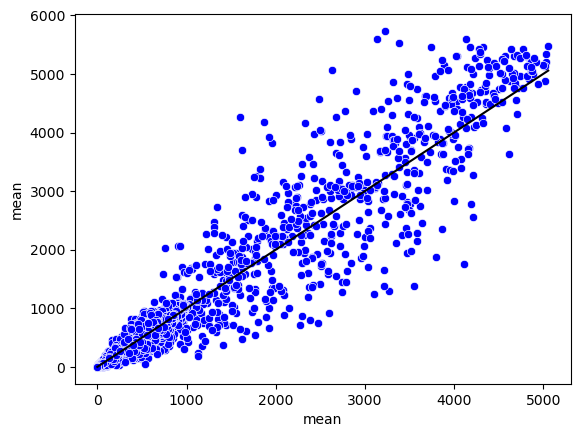

In [ ]:
sns.lineplot(data=predictions, x="mean", y="mean",color='black')
sns.scatterplot(data=predictions, x="mean", y="pv_measurement",color='blue')

In [ ]:

#predictions['prediction_xtreme'] = predictions['mean'] + (predictions['mean'] - predictions['lin_reg'])*0.2
predictions['prediction_xtreme_only_high'] = np.where(predictions['mean'] > 4000, predictions['mean'] + 350, predictions['mean']*1.04)


prediction_xtreme_only_high = mean_absolute_error(predictions['pv_measurement'], predictions['prediction_xtreme_only_high'])
mae = mean_absolute_error(predictions['pv_measurement'], predictions['mean'])

print(f'MAE: {mae}')
print(f'MAE Xtreme 2: {prediction_xtreme_only_high}')

MAE: 130.32586866173412
MAE Xtreme 2: 126.50959943660364


<Axes: xlabel='mean', ylabel='prediction_xtreme_only_high'>

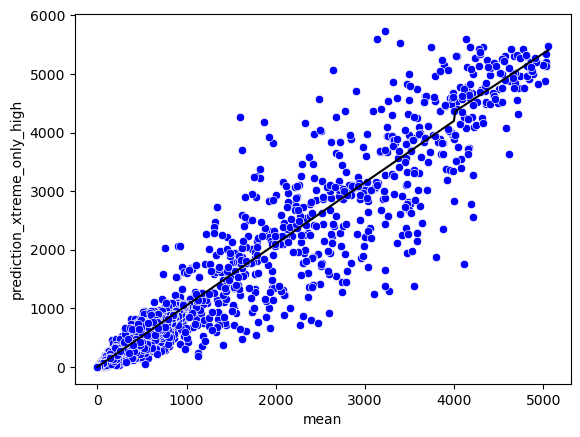

In [ ]:
sns.lineplot(data=predictions, x="mean", y="prediction_xtreme_only_high",color='black')
sns.scatterplot(data=predictions, x="mean", y="pv_measurement",color='blue')

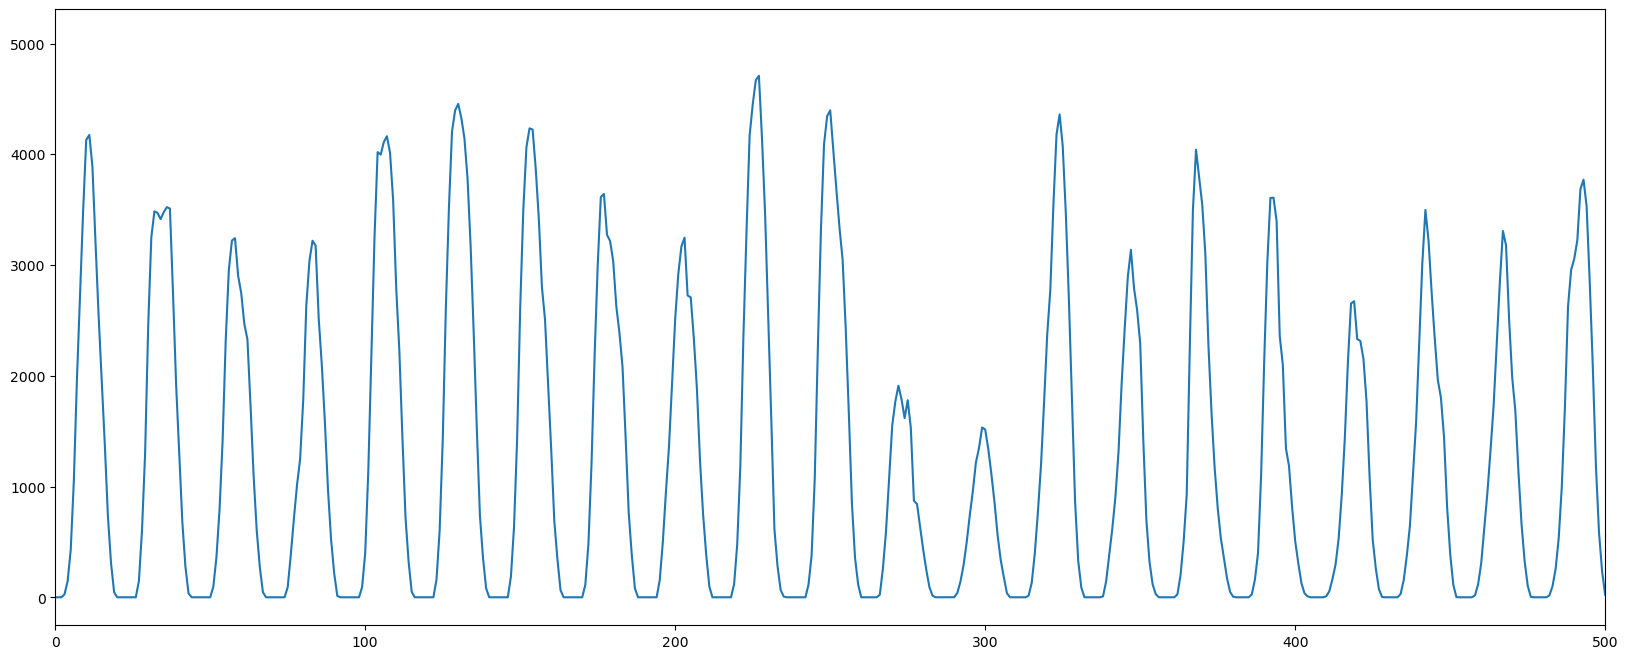

In [ ]:
pred_only_pred = predictions.iloc[:,-1:]
#pred_only_pred = predictions.iloc[:,-12:]
plt.figure(figsize=(20,8))
plt.xlim(0,500)
#plt.ylim(-20,100)
plt.plot(pred_only_pred);

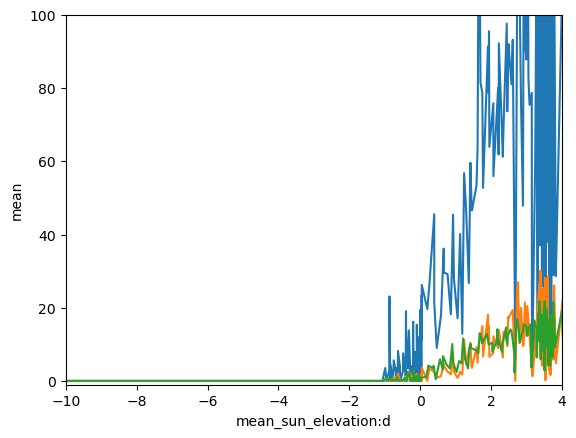

In [ ]:
#predictions['mean'] = pred_only_pred.mean(axis=1)
plt.xlim(-10,4)
plt.ylim(-1,100)
sns.lineplot(data=predictions, x='mean_sun_elevation:d', y='mean', hue='building_id', legend=False);

Text(0.5, 1.0, 'Building c')

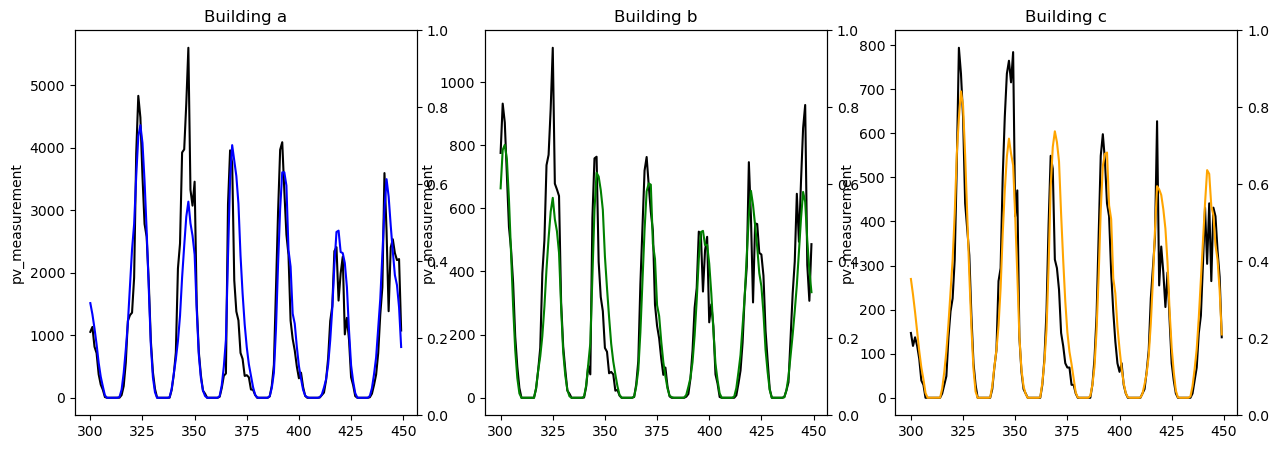

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 300
end_idx = start_idx + 150

x = predictions.index[start_idx:end_idx]

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=x, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=x, y='mean', ax=axs[0],color='blue')
ax0_twin = axs[0].twinx()
# sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=predictions.index[start_idx:end_idx], y='mean_is_in_shadow:idx', ax=ax0_twin,color='grey')


sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=x, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=x, y='mean', ax=axs[1],color='green')
ax1_twin = axs[1].twinx()
# sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=predictions.index[start_idx:end_idx], y='mean_is_in_shadow:idx', ax=ax1_twin,color='grey')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=x, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=x, y='mean', ax=axs[2],color='orange')
ax2_twin = axs[2].twinx()
# sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=predictions.index[start_idx:end_idx], y='mean_is_in_shadow:idx', ax=ax2_twin,color='grey')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

Text(0.5, 1.0, 'Building c')

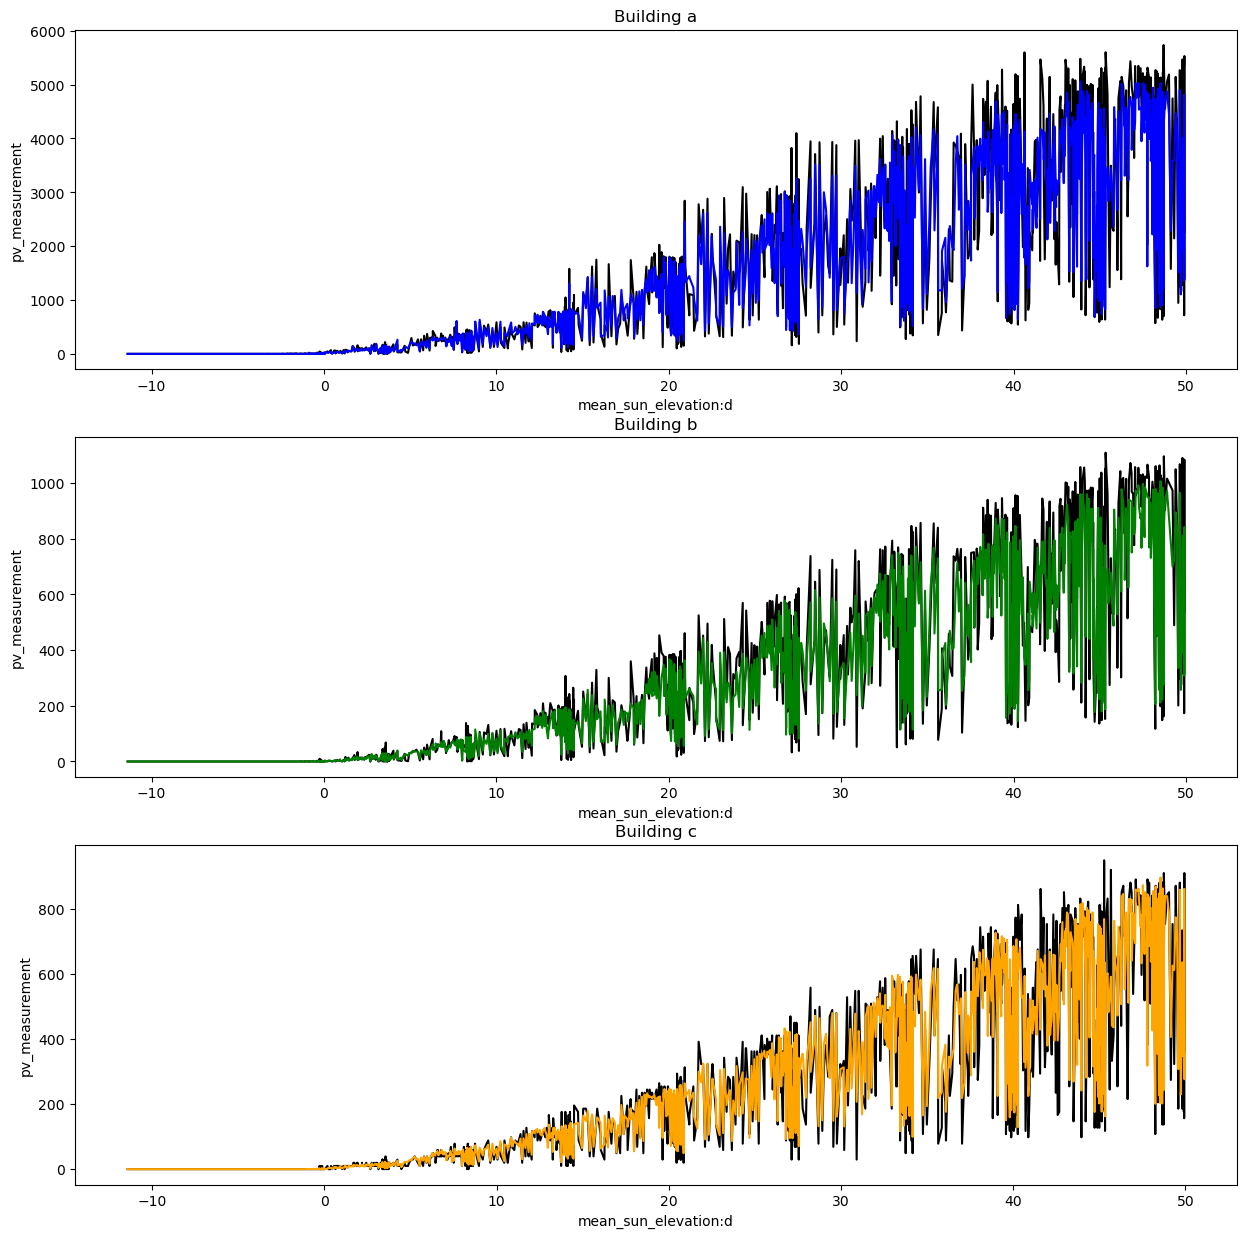

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

start_idx = 0
end_idx = 10000#start_idx + 150

feature_name = 'mean_sun_elevation:d'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='blue')

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='green')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='orange')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

Text(0.5, 1.0, 'Building c')

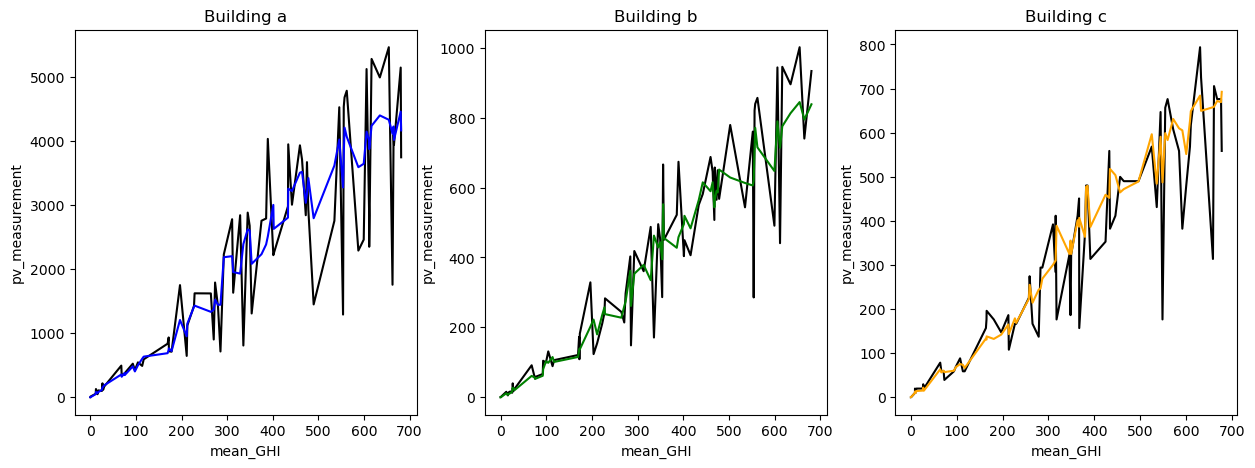

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 100
end_idx = 200#start_idx + 150

feature_name = 'mean_GHI'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='blue')

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='green')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='orange')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

In [ ]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_elevation:m,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_date_calc,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,mean_effective_cloud_cover:p_-1h,mean_effective_cloud_cover:p_1h,mean_cloud_base_agl:m_-1h,mean_cloud_base_agl:m_1h,pv_measurement,mean
0,a,2021-05-01 00:00:00,0,NaN,2021-05-01 00:00:00,2021-05-01,2021-05,5,0,4.750,1.28800,2263.399902,0.000000,0.000000,383.899994,0.00,272.850006,0.000000,0.000000,0.000,0.000000,80.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1016.575012,0.0,0.0,1003.450012,1009.724976,0.0,0.0,86.250000,1016.025024,NaN,0.0,0.0,0.0,0.00,15.557000,-10.45100,0.05,274.100006,80.175003,16891.125000,1.900,1.850,0.400,0.0,NaT,0.000000,1.359342,0.000000,163.937500,0.000000,0.977416,0.209815,0.000000,1.000000,189.842712,206.237955,NaN,0.000000,0.000000,0.000000,0.000000,92.400002,73.224998,388.250000,448.549988,0.00,0.000000
1,a,2021-05-01 01:00:00,0,NaN,2021-05-01 01:00:00,2021-05-01,2021-05,5,1,4.600,1.28750,1671.375000,0.000000,0.000000,388.250000,0.00,272.549988,0.000000,0.000000,0.000,0.000000,92.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1016.825012,0.0,0.0,1003.599976,1009.900024,0.0,0.0,85.599998,1016.200012,NaN,0.0,0.0,0.0,0.00,30.024000,-7.85575,0.10,273.924988,92.425003,17319.949219,1.625,1.600,0.300,0.0,NaT,0.000000,1.385789,0.000000,139.107513,0.000000,0.982041,0.183787,0.258819,0.965926,189.842712,206.237955,NaN,0.000000,0.000000,0.000000,0.000000,98.125000,80.099998,347.475006,383.899994,0.00,0.000000
2,a,2021-05-01 02:00:00,0,NaN,2021-05-01 02:00:00,2021-05-01,2021-05,5,2,4.650,1.28575,1051.675049,0.000000,0.000000,347.475006,0.00,272.649994,0.000000,0.000000,0.000,0.000000,98.125000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1016.900024,0.0,0.0,1003.599976,1009.900024,0.0,0.0,86.800003,1016.200012,NaN,0.0,0.0,0.0,0.05,44.045750,-3.82025,0.10,273.799988,98.125000,16589.625000,1.675,1.600,0.425,0.0,NaT,0.000000,1.311341,0.000000,145.372498,0.000000,0.966227,0.256470,0.500000,0.866025,189.842712,206.237955,94.12000,4.125000,0.000000,1129.012451,0.000000,98.125000,92.400002,323.350006,388.250000,0.00,0.000000
3,a,2021-05-01 03:00:00,0,NaN,2021-05-01 03:00:00,2021-05-01,2021-05,5,3,4.750,1.28475,1624.300049,9835.325195,11.400000,323.350006,0.00,272.950012,3.975000,7132.049805,0.150,282.500000,98.125000,6.0,0.0,0.0,0.0,0.0,0.0,0.75,0.5,1016.900024,0.0,0.0,1003.599976,1009.900024,0.0,0.0,88.349998,1016.200012,NaN,0.0,0.0,0.0,0.10,57.613750,1.37325,0.20,273.700012,98.125000,14928.175781,1.525,1.450,0.400,0.0,NaT,4.125000,1.300201,1129.012451,134.707504,11.096075,0.963420,0.267251,0.707107,0.707107,189.842712,206.237955,96.85250,23.049999,0.000000,6308.427734,0.000000,98.824997,98.125000,289.200012,347.475006,55.22,26

In [ ]:

predictions['lin_reg'] = 0



for build_id in predictions['building_id'].unique():
    linreg = LinearRegression(fit_intercept=False)

    X_lin = predictions[(predictions['building_id']==build_id) & (predictions['pv_measurement'] > 0)][['mean_GHI']].copy()
    y_lin = predictions[(predictions['building_id']==build_id) & (predictions['pv_measurement'] > 0)]['mean'].copy()

    linreg.fit(X_lin, y_lin)

    # Make predictions
    predictions.loc[predictions['building_id']==build_id,'lin_reg'] = linreg.predict(predictions[predictions['building_id']==build_id][['mean_GHI']])



In [ ]:
predictions['prediction_xtreme'] = predictions['mean'] + (predictions['mean'] - predictions['lin_reg'])*0.2

In [ ]:

#predictions['prediction_xtreme'] = predictions['mean'] + (predictions['mean'] - predictions['lin_reg'])*0.2
predictions.loc[predictions['building_id']=='a','prediction_xtreme'] = np.where(
    predictions[predictions['building_id']=='a']['mean'] - predictions[predictions['building_id']=='a']['lin_reg']>0,
    predictions[predictions['building_id']=='a']['mean']*1.05,
    predictions[predictions['building_id']=='a']['mean']*1.01
    )

predictions.loc[predictions['building_id']=='b','prediction_xtreme'] = np.where(
    predictions[predictions['building_id']=='b']['mean'] - predictions[predictions['building_id']=='b']['lin_reg']>0,
    predictions[predictions['building_id']=='b']['mean']*1.08,
    predictions[predictions['building_id']=='b']['mean']*1.06
    )
predictions.loc[predictions['building_id']=='c','prediction_xtreme'] = np.where(
    predictions[predictions['building_id']=='c']['mean'] - predictions[predictions['building_id']=='c']['lin_reg']>0,
    predictions[predictions['building_id']=='c']['mean']*1.02,
    predictions[predictions['building_id']=='c']['mean']*0.98
    )

predictions['prediction_xtreme_2'] = np.where(
    predictions['mean'] - predictions['lin_reg']>0,
    1.06*predictions['mean'],
    1.02*predictions['mean']
    )


mae_xtreme_2 = mean_absolute_error(predictions['pv_measurement'], predictions['prediction_xtreme_2'])
mae_xtreme = mean_absolute_error(predictions['pv_measurement'], predictions['prediction_xtreme'])
mae = mean_absolute_error(predictions['pv_measurement'], predictions['mean'])

print(f'MAE: {mae}')
print(f'MAE Xtreme: {mae_xtreme}')
print(f'MAE Xtreme 2: {mae_xtreme_2}')

MAE: 130.32586866173412
MAE Xtreme: 125.52641495802716
MAE Xtreme 2: 125.94878838516895


Text(0.5, 1.0, 'Building c')

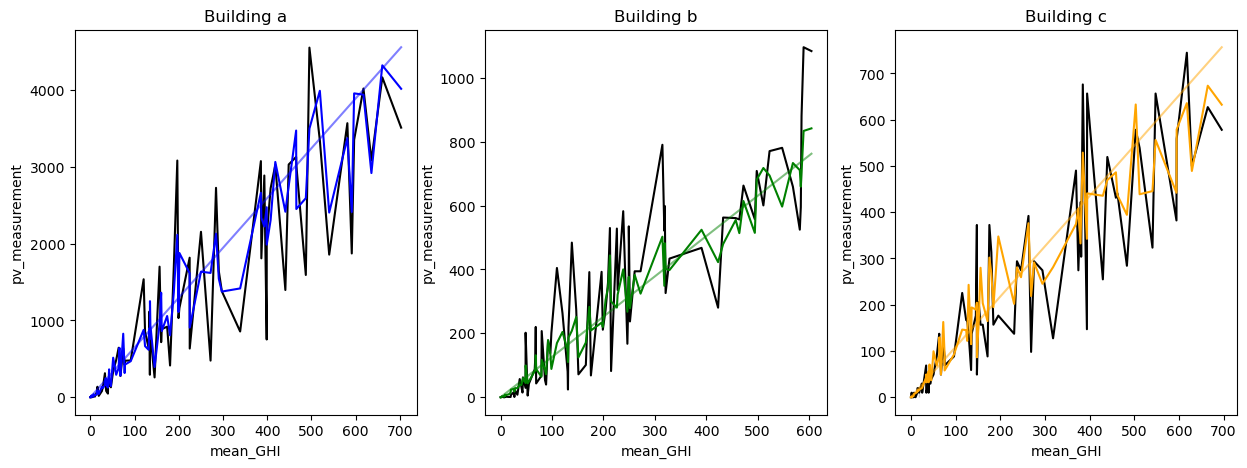

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 1100
end_idx = start_idx+100#start_idx + 150

feature_name = 'mean_GHI'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='blue')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='lin_reg', ax=axs[0],color='blue',alpha=0.5)

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='green')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='lin_reg', ax=axs[1],color='green',alpha=0.5)

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='orange')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='lin_reg', ax=axs[2],color='orange',alpha=0.5)

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

Text(0.5, 1.0, 'Building c')

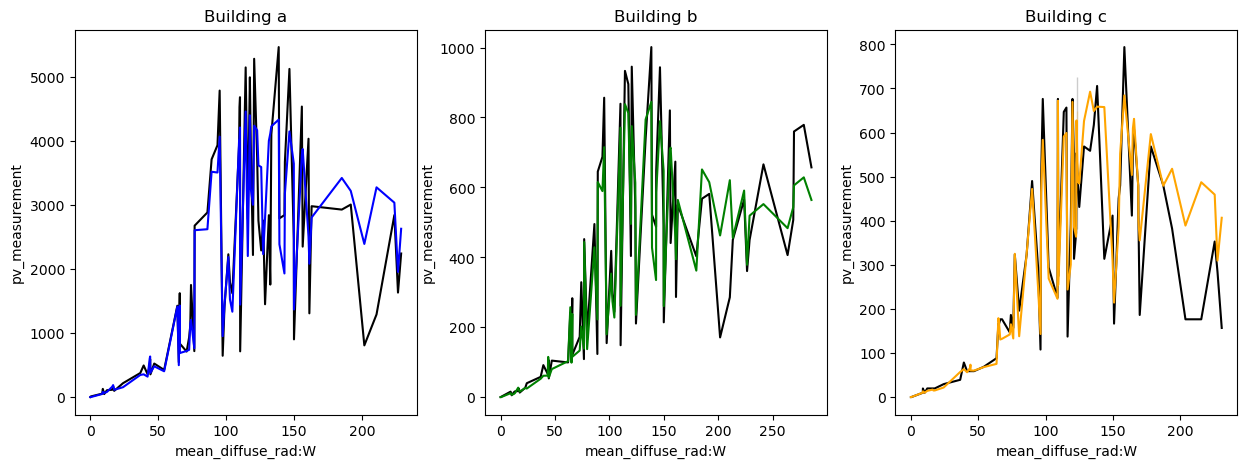

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 100
end_idx = 200#start_idx + 150

feature_name = 'mean_diffuse_rad:W'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='blue')

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='green')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='black')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='orange')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

Text(0.5, 1.0, 'Building c')

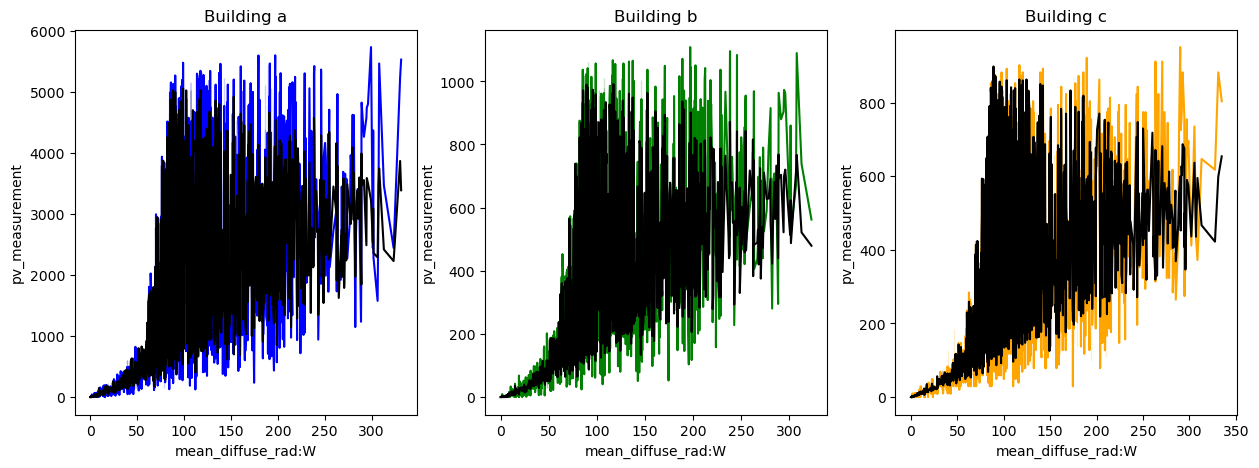

In [ ]:
val_X, val_y = m_wrap.get_val(aggregated=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

start_idx = 0
end_idx = 10000#start_idx + 150

feature_name = 'mean_diffuse_rad:W'

sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[0],color='blue')
sns.lineplot(data=predictions[predictions['building_id']=='a'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[0],color='black')

sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[1],color='green')
sns.lineplot(data=predictions[predictions['building_id']=='b'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[1],color='black')

sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='pv_measurement', ax=axs[2],color='orange')
sns.lineplot(data=predictions[predictions['building_id']=='c'][start_idx:end_idx], x=feature_name, y='mean', ax=axs[2],color='black')

axs[0].set_title('Building a')
axs[1].set_title('Building b')
axs[2].set_title('Building c')

In [ ]:
predictions['mean'] = predictions['mean'].clip(0)
predictions.loc[predictions['mean_sun_elevation:d'] <-1,'mean'] = 0

In [ ]:
predictions['mean'].to_csv('catBoost_ensemble_12.csv', index=True)

# Ideas
Bagging:
    - building
    - hour / sun elevation
    - (sunny day)
Stacking
    - xgboost, random forest, catboost, lightgbm
    - different aggregations
        - max, min
        - time values
        - mean, std
        - (everything)
    - random seed

# Combine Predictions